# Loading data

In the repo a syntetical data (generated by a special GAN) is available to test the notebook. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import shap
import lime
import eli5

featuretype = pd.read_csv('feature_types.csv', sep=';')
df_imp_wonan_dumm2 = pd.read_csv('data_clean_onehot.csv', sep=';')

# preprocess
df_imp_wonan_dumm = df_imp_wonan_dumm2.sample(frac=1)
dataset = df_imp_wonan_dumm.values
# test and validation ratio
test_step = .1
valid_step = .1

# features and output
X = dataset[:,0:-1]
Y = dataset[:,-1]

# indexing
valid_index = int(X.shape[0]*(1-valid_step-test_step))
test_index = int(X.shape[0]*(1-test_step))

# test split
X_test = X[test_index:]
Y_test = Y[test_index:]
#Y_test = to_categorical(Y[test_index:],2)

# validation split
X_valid = X[valid_index:test_index]
Y_valid = Y[valid_index:test_index]
#Y_valid = to_categorical(Y[valid_index:test_index],2)

# training split
X_train = X[:test_index]
Y_train = Y[:test_index]
#Y_train = to_categorical(Y[:test_index],2)


# MinMax scaling

scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)
x_valid = scaler.transform(X_valid)
y_train = Y_train.astype(int)
y_test = Y_test.astype(int)
y_valid = Y_valid.astype(int)



# Tensorflow keras

Dummy model, probably will be replaced with the more sofisticated TabNet model architecture later.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4888 samples, validate on 543 samples
Epoch 1/100
4320/4888 [=========================>....] - ETA: 0s - loss: 0.6986 - acc: 0.5113
Epoch 00001: val_loss improved from inf to 0.68118, saving model to model.hdf5
4888/4888 [==============================] - 1s 147us/sample - loss: 0.6972 - acc: 0.5135 - val_loss: 0.6812 - val_acc: 0.6298
Epoch 2/100
4608/4888 [===========================>..] - ETA: 0s - loss: 0.6843 - acc: 0.5490
Epoch 00002: val_loss improved from 0.68118 to 0.66398, saving model to model.hdf5
4888/4888 [==============================] - 0s 94us/sample - loss: 0.6838 - acc: 0.5509 - val_loss: 0.6640 - val_acc: 0.6575
Epoch 3/100
4800/4888 [============================>.] - ETA: 0s - loss: 0.6777 - acc: 0.5838
Epoch 00003: val_loss improved from 0.66398 to 0.64340, saving model to model.hdf

4672/4888 [===========================>..] - ETA: 0s - loss: 0.6245 - acc: 0.6657
Epoch 00027: val_loss did not improve from 0.59496
4888/4888 [==============================] - 0s 72us/sample - loss: 0.6247 - acc: 0.6659 - val_loss: 0.6176 - val_acc: 0.6703
Epoch 28/100
4704/4888 [===========================>..] - ETA: 0s - loss: 0.6246 - acc: 0.6624
Epoch 00028: val_loss did not improve from 0.59496
4888/4888 [==============================] - 0s 71us/sample - loss: 0.6248 - acc: 0.6614 - val_loss: 0.6264 - val_acc: 0.6390
Epoch 29/100
4608/4888 [===========================>..] - ETA: 0s - loss: 0.6235 - acc: 0.6632
Epoch 00029: val_loss did not improve from 0.59496
4888/4888 [==============================] - 0s 74us/sample - loss: 0.6239 - acc: 0.6628 - val_loss: 0.5983 - val_acc: 0.6998
Epoch 00029: early stopping
Evaluation
544/544 [==============================] - 0s 32us/sample - loss: 0.6318 - acc: 0.6360


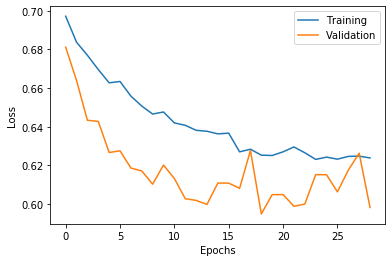

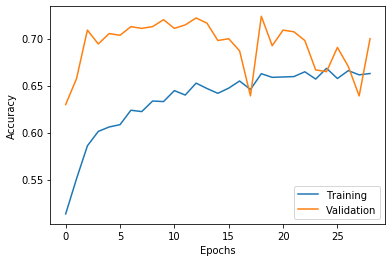

In [2]:

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)

# Build the tf.keras.Sequential model by stacking layers.

#kernin = 'glorot_uniform'
#kernin = 'glorot_normal'
#kernin = tf.keras.initializers.RandomUniform(-1,1)
#kernin = tf.keras.initializers.Zeros()
#kernin = tf.keras.initializers.Ones()

def create_model(dense_layer_sizes = (32,15,10), dropout_ratios = (.5,.5),
                 kernin = 'glorot_normal', opti = SGD(learning_rate=.1)):
    
    # input sanity checks
    while len(dropout_ratios) > len(dense_layer_sizes)-1:
        dropout_ratios = dropout_ratios[:-1]
    while len(dropout_ratios) < len(dense_layer_sizes)-1:
        dropout_ratios.append(0)
        
    model = Sequential()
    model.add(Dense(dense_layer_sizes[0], activation='relu', kernel_initializer=kernin, input_shape=(32,)))
    for i, j in zip(dense_layer_sizes[1:], dropout_ratios): 
        if j != 0:
            model.add(Dropout(j))
        model.add(Dense(i, activation='relu', kernel_initializer=kernin))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernin)) # softmax csak 2-dim kimenetre tanul
    
    model.compile(optimizer=opti,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()

# Train and evaluate model:
network_history=model.fit(x_train,Y_train, 
            batch_size=32, 
            epochs=100, 
            verbose=1,
            shuffle=True,
            validation_data=(x_valid, Y_valid), 
            callbacks=[early_stopping, checkpointer])

print("Evaluation")
model.evaluate(x_test, Y_test)

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

## Sklearn wrapper around the keras model

 we need this because some of the interpretability packages only work with sklearn models

In [3]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

my_classifier = KerasClassifier(create_model,
                                batch_size=32, 
                                epochs=100, 
                                verbose=1,
                                shuffle=True,
                                validation_data=(x_valid, Y_valid))
fitted_history = my_classifier.fit(x_train, Y_train)

Train on 4888 samples, validate on 543 samples
Epoch 1/100
4888/4888 [==============================] - 1s 114us/sample - loss: 0.7005 - acc: 0.5033 - val_loss: 0.6860 - val_acc: 0.5783
Epoch 2/100
4888/4888 [==============================] - 0s 82us/sample - loss: 0.6874 - acc: 0.5378 - val_loss: 0.6733 - val_acc: 0.6427
Epoch 3/100
4888/4888 [==============================] - 0s 72us/sample - loss: 0.6795 - acc: 0.5685 - val_loss: 0.6643 - val_acc: 0.6298
Epoch 4/100
4888/4888 [==============================] - 0s 94us/sample - loss: 0.6722 - acc: 0.5861 - val_loss: 0.6473 - val_acc: 0.6777
Epoch 5/100
4888/4888 [==============================] - 0s 81us/sample - loss: 0.6626 - acc: 0.5978 - val_loss: 0.6347 - val_acc: 0.6796
Epoch 6/100
4888/4888 [==============================] - 0s 77us/sample - loss: 0.6617 - acc: 0.6142 - val_loss: 0.6366 - val_acc: 0.6832
Epoch 7/100
4888/4888 [==============================] - 0s 75us/sample - loss: 0.6533 - acc: 0.6287 - val_loss: 0.6310 - va

4888/4888 [==============================] - 0s 89us/sample - loss: 0.6003 - acc: 0.6845 - val_loss: 0.5801 - val_acc: 0.7164
Epoch 60/100
4888/4888 [==============================] - 0s 82us/sample - loss: 0.6000 - acc: 0.6851 - val_loss: 0.5635 - val_acc: 0.7109
Epoch 61/100
4888/4888 [==============================] - 0s 96us/sample - loss: 0.5978 - acc: 0.6948 - val_loss: 0.5596 - val_acc: 0.7274
Epoch 62/100
4888/4888 [==============================] - 0s 92us/sample - loss: 0.5913 - acc: 0.6925 - val_loss: 0.5666 - val_acc: 0.7090
Epoch 63/100
4888/4888 [==============================] - 0s 78us/sample - loss: 0.5942 - acc: 0.6962 - val_loss: 0.5590 - val_acc: 0.7182
Epoch 64/100
4888/4888 [==============================] - 1s 104us/sample - loss: 0.5911 - acc: 0.6964 - val_loss: 0.5539 - val_acc: 0.7256
Epoch 65/100
4888/4888 [==============================] - 0s 93us/sample - loss: 0.5912 - acc: 0.6972 - val_loss: 0.5526 - val_acc: 0.7274
Epoch 66/100
4888/4888 [===============

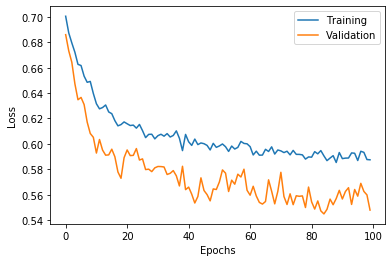

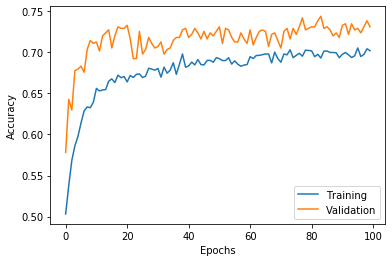

In [4]:
plot_history(fitted_history)

In [5]:
print(model.predict(x_test[:5,]), '\n',
      my_classifier.predict(x_test[:5,]), '\n',
      my_classifier.predict_proba(x_test[:5,]), '\n',
      my_classifier.score(x_test[:50,], Y_test[:50]))

50/50 [==============================] - 0s 178us/sample - loss: 0.6444 - acc: 0.6400
[[0.64405906]
 [0.68754244]
 [0.6869564 ]
 [0.5404877 ]
 [0.64669997]] 
 [[1.]
 [1.]
 [1.]
 [0.]
 [1.]] 
 [[0.2856477  0.7143523 ]
 [0.17634654 0.82365346]
 [0.12969953 0.8703005 ]
 [0.6042555  0.3957445 ]
 [0.18179584 0.81820416]] 
 0.64


### validation of the dummy model

work in progress

In [6]:
# dense_size_candidates = [(23,15,10,5), (23,15,10), (23,15), (23,30,23)]
# dropout_candidates = [(.2,.5,.8), (.5,), (.2), (.2,.3)]
# kern_candid = ['glorot_normal', 'glorot_uniform', tf.keras.initializers.RandomUniform(-1,1)]
# opt_candid = ['adam', 'sgd', SGD(learning_rate=.1), SGD(learning_rate=1)]
                                
# validator = GridSearchCV(my_classifier,
#                          param_grid={'dense_layer_sizes': dense_size_candidates,
#                                      'dropout_ratios': dropout_candidates,
#                                      'kernin': kern_candid,
#                                      'opti': opt_candid,
#                                      'epochs': [10, 30, 50]},
#                          # epochs is avail for tuning even when not argument to model building function
#                          scoring='neg_log_loss',
#                          n_jobs=1)
# validator.fit(x_train, Y_train)

# print('The parameters of the best model are: ')
# print(validator.best_params_)

# # validator.best_estimator_ returns sklearn-wrapped version of best model.
# # validator.best_estimator_.model returns the (unwrapped) keras model
# best_model = validator.best_estimator_.model
# metric_names = best_model.metrics_names
# metric_values = best_model.evaluate(x_test, y_test)
# for metric, value in zip(metric_names, metric_values):
#     print(metric, ': ', value)

# XGBoost

for comparison with the NN model

In [7]:
import xgboost
from sklearn.metrics import accuracy_score
gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(x_train, Y_train)

print(accuracy_score(Y_train, gbtree.predict(x_train)))
print(accuracy_score(Y_test, gbtree.predict(x_test)))

0.9150981996726678
0.6911764705882353


# RandomForestClassifier

for comparison with the NN model

In [8]:
from sklearn.ensemble import RandomForestClassifier
mod = RandomForestClassifier(n_estimators=100, max_depth= 5)
mod.fit(x_train, y_train)

print(mod.score(x_train,y_train))
print(mod.score(x_test, y_test))

0.7054009819967266
0.6654411764705882


In [9]:
all_feature_cols = list(df_imp_wonan_dumm2)[:-1]
pd.DataFrame({"feat": all_feature_cols, "sc":mod.feature_importances_}).sort_values("sc")

,feat,sc
3,Szervezet_neve_Természettudományi Kar,0.000712
8,ks_helye_Egyéb,0.000837
14,verseny,0.000926
4,Szervezet_neve_Vegyészmérnöki és Biomérnöki Kar,0.001635
9,ks_helye_Főváros,0.001793
7,Szervezet_neve_Építőmérnöki Kar,0.001871
10,ks_helye_Nagyváros (megyei jogú),0.001935
2,Szervezet_neve_Közlekedésmérnöki és Járműmérnö...,0.002088
24,idegen_nyelv_ks,0.002601
6,Szervezet_neve_Építészmérnöki Kar,0.003866


# Interpretability packages

We will try out and further investigate the methods and packages listed below.

### Feature types

We need to get back the information about the types of the features in order to use the interpretability methods later.

In [10]:
cat_cols = [i[1]['name'] for i in featuretype.iterrows() if i[1]['type']=='category' ]
print(cat_cols)

num_cols = [i[1]['name'] for i in featuretype.iterrows() if i[1]['type']=='numeric' ]
print(num_cols)

bool_cols = [i[1]['name'] for i in featuretype.iterrows() if i[1]['type']=='bool' ]
print(bool_cols)

all_feature_cols = cat_cols + bool_cols + num_cols

['Szervezet_neve_Gazdaság- és Társadalomtudományi Kar', 'Szervezet_neve_Gépészmérnöki Kar', 'Szervezet_neve_Közlekedésmérnöki és Járműmérnöki Kar', 'Szervezet_neve_Természettudományi Kar', 'Szervezet_neve_Vegyészmérnöki és Biomérnöki Kar', 'Szervezet_neve_Villamosmérnöki és Informatikai Kar', 'Szervezet_neve_Építészmérnöki Kar', 'Szervezet_neve_Építőmérnöki Kar', 'ks_helye_Egyéb', 'ks_helye_Főváros', 'ks_helye_Nagyváros (megyei jogú)']
['felvi_osszes_skalazott', 'Hozott/Tanulmányi_pontszám', 'Szerzett/Érettségi_pontsz', 'tobblet_skalazott', 'idegen_nyelv', 'magyar nyelv és irodalom', 'matematika', 'történelem', 'választott_tárgy', 'idegen_nyelv_ks', 'magyar_irodalom_ks', 'magyar_nyelvtan_ks', 'matematika_ks', 'történelem_ks', 'választható_tantárgy_ks', 'nyv_pontok', 'erettsegi_ota_eltelt_évek']
['allamilag_tamogatott', 're_enrolled', 'nem_ferfi', 'verseny']


In [11]:
target_var = 'Statusz_vegzett'

# pdpbox

In [12]:
#from sklearn.inspection import plot_partial_dependence
#plot_partial_dependence(my_classifier, x_train, ["felvi_osszes_skalazott"], all_feature_cols)

from pdpbox import pdp, get_dataset, info_plots

bigdf =pd.DataFrame(x_train, columns=all_feature_cols)
bigdf[target_var] = Y_train

for c in cat_cols + [target_var]:
    bigdf[c] = bigdf[c].astype('category')
    
bigdf.head()


,Szervezet_neve_Gazdaság- és Társadalomtudományi Kar,Szervezet_neve_Gépészmérnöki Kar,Szervezet_neve_Közlekedésmérnöki és Járműmérnöki Kar,Szervezet_neve_Természettudományi Kar,Szervezet_neve_Vegyészmérnöki és Biomérnöki Kar,Szervezet_neve_Villamosmérnöki és Informatikai Kar,Szervezet_neve_Építészmérnöki Kar,Szervezet_neve_Építőmérnöki Kar,ks_helye_Egyéb,ks_helye_Főváros,...,választott_tárgy,idegen_nyelv_ks,magyar_irodalom_ks,magyar_nyelvtan_ks,matematika_ks,történelem_ks,választható_tantárgy_ks,nyv_pontok,erettsegi_ota_eltelt_évek,Statusz_vegzett
0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,0.550000,1.000000,0.000000,0.333333,0.333333,0.333333,1.000000,0.5,-0.666667,0.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-0.166667,1.000000,0.333333,0.333333,1.000000,0.666667,1.000000,-0.5,-0.583333,0.0
2,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.016667,0.666667,0.666667,0.666667,0.333333,0.666667,0.333333,-0.5,-1.000000,1.0
3,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.350000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,-0.833333,1.0
4,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.450000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.5,-1.000000,0.0


4888/4888 [==============================] - 0s 31us/sample


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


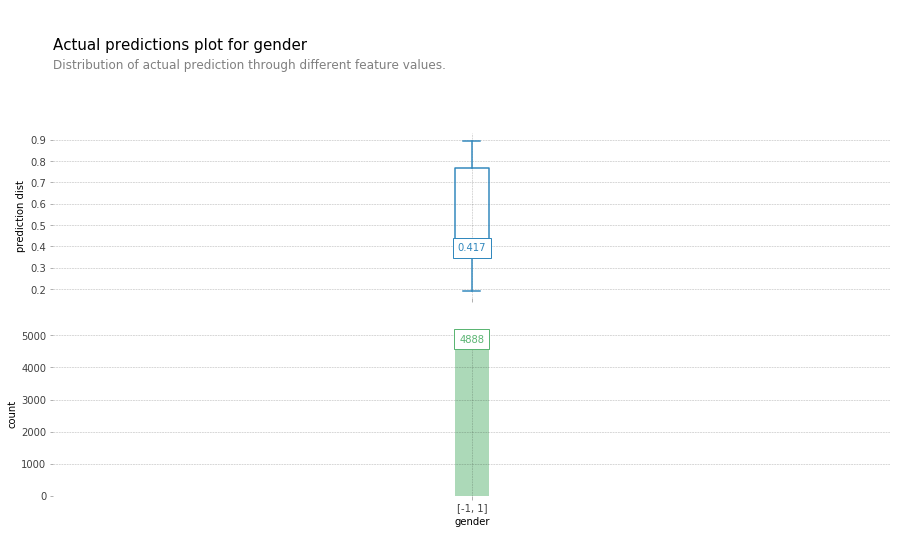

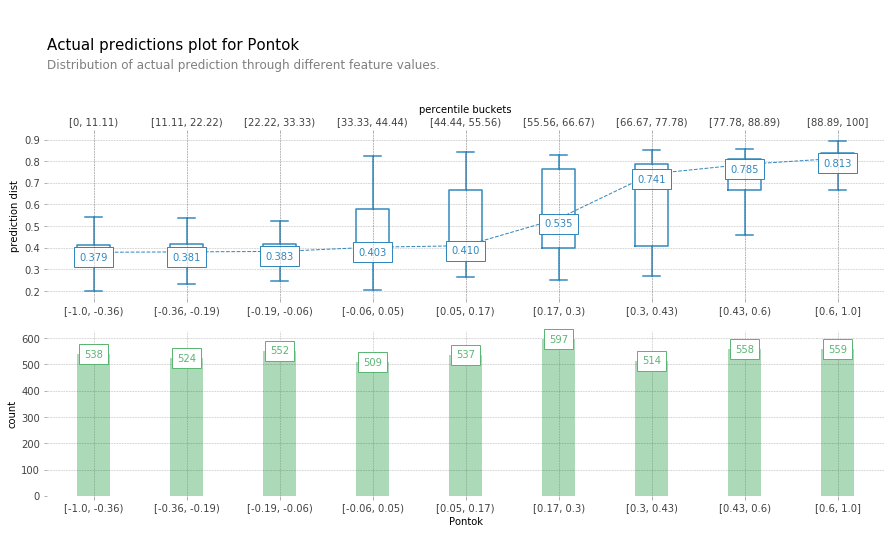

In [13]:
# fig, axes, summary_df = info_plots.target_plot(
#     df=bigdf, feature='nem_ferfi', feature_name='gender',
#     target='Statusz_vegzett')
# _ = axes['bar_ax'].set_xticklabels(['Female','Male'])

fig, axes, summary_df = info_plots.actual_plot(
     model=my_classifier, X=bigdf[all_feature_cols],
     feature='nem_ferfi', feature_name='gender', predict_kwds = {})

# fig, axes, summary_df = info_plots.target_plot(
#     df=bigdf, feature='felvi_osszes_skalazott', feature_name='felvi_pontok',
#     target=target_var, show_percentile=True)

fig, axes, summary_df = info_plots.actual_plot(
    model=my_classifier, X=bigdf[all_feature_cols],
    feature='felvi_osszes_skalazott', feature_name='Pontok', 
    show_percentile=True, predict_kwds = {})

# Local Interpretable Model-agnostic Explanations (LIME)

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(Y_train)
class_names = le.classes_

cat_cols_indeces=[]
cat_names={}
for i, c in enumerate(list(df_imp_wonan_dumm)):
    if c in cat_cols + bool_cols:
        le = LabelEncoder()
        le.fit(x_train[:, i])
        cat_cols_indeces.append(c)
        cat_names[c]=le.classes_
        
print(cat_names)

{'Szervezet_neve_Gazdaság- és Társadalomtudományi Kar': array([-1.,  1.]), 'Szervezet_neve_Gépészmérnöki Kar': array([-1.,  1.]), 'Szervezet_neve_Közlekedésmérnöki és Járműmérnöki Kar': array([-1.,  1.]), 'Szervezet_neve_Természettudományi Kar': array([-1.,  1.]), 'Szervezet_neve_Vegyészmérnöki és Biomérnöki Kar': array([-1.,  1.]), 'Szervezet_neve_Villamosmérnöki és Informatikai Kar': array([-1.,  1.]), 'Szervezet_neve_Építészmérnöki Kar': array([-1.,  1.]), 'Szervezet_neve_Építőmérnöki Kar': array([-1.,  1.]), 'ks_helye_Egyéb': array([-1.,  1.]), 'ks_helye_Főváros': array([-1.,  1.]), 'ks_helye_Nagyváros (megyei jogú)': array([-1.,  1.]), 'allamilag_tamogatott': array([-1.,  1.]), 're_enrolled': array([-1.,  1.]), 'nem_ferfi': array([-1.,  1.]), 'verseny': array([-1.,  1.])}


In [15]:
lexplainer = lime.lime_tabular.LimeTabularExplainer(x_train,
                                                    mode='classification',
                                                    feature_names = all_feature_cols,
                                                    class_names = class_names,
                                                    categorical_features=cat_cols_indeces, 
                                                    categorical_names=cat_names)

np.random.seed(1)
i = 23
exp = lexplainer.explain_instance(x_test[i,:], my_classifier.predict_proba)
exp.show_in_notebook(show_all=True)

5000/5000 [==============================] - 0s 59us/sample


# Shapley Value (SHAP)

In [16]:
# initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
background = x_train
explainer = shap.GradientExplainer(model, data=background)


# Fit the explainer on a subset of the data (you can try all but then gets slower)
data_for_prediction = x_train[:20]
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(0, shap_values[0], data_for_prediction)

# Skater

package of Oracle; contains another implementation of pdp and some kind of feature importance

544/544 [==============================] - 0s 63us/sample


2019-11-19 21:10:46,881 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2019-11-19 21:10:47,048 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


544/544 [==============================] - 0s 29us/sampleon
[32/32] features ████████████████████ Time elapsed: 5 seconds

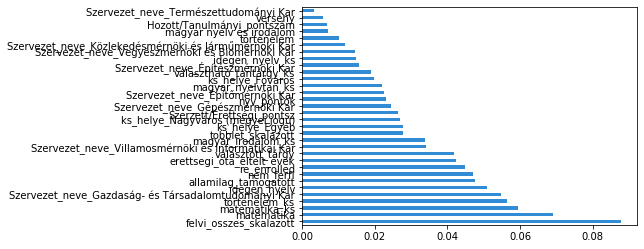

In [17]:
import skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(x_test, feature_names=all_feature_cols)
memmodel = InMemoryModel(my_classifier.predict_proba, examples=x_train)
plots = interpreter.feature_importance.plot_feature_importance(memmodel, ascending = False)

4888/4888 [==============================] - 0s 58us/sample


2019-11-19 21:10:54,652 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2019-11-19 21:10:54,671 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


1000/1000 [==============================] - 0s 26us/sampleon
[30/30] grid cells ████████████████████ Time elapsed: 5 seconds

2019-11-19 21:11:00,155 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2019-11-19 21:11:00,172 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


1000/1000 [==============================] - 0s 27us/sample
[2/2] grid cells ████████████████████ Time elapsed: 0 seconds

(0, 1)

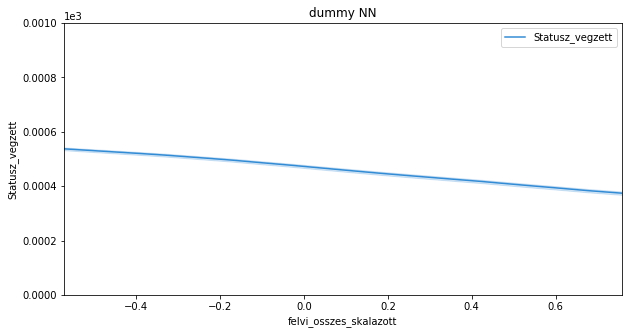

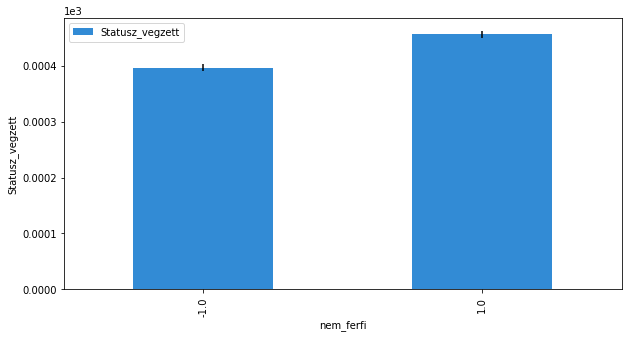

In [18]:
pyint_model = InMemoryModel(my_classifier.predict_proba, examples=x_train,
                            feature_names=all_feature_cols,
                            target_names=[target_var])
axes_list = interpreter.partial_dependence.plot_partial_dependence(['felvi_osszes_skalazott', 'nem_ferfi'],
                                                                   pyint_model, 
                                                                   grid_resolution=30, 
                                                                   with_variance=True,
                                                                   figsize = (10, 5))
ax = axes_list[0][1]
ax.set_title('dummy NN')
ax.set_ylim(0, 1)

# Eli5
### Permuted Feature Importance

In [19]:
from eli5.sklearn import PermutationImportance
import numpy as np
from sklearn.metrics import accuracy_score
from eli5.permutation_importance import get_score_importances

perm = PermutationImportance(my_classifier, random_state=1).fit(x_train,Y_train, verbose=0)
eli5.show_weights(perm, feature_names = all_feature_cols)

4888/4888 [==============================] - 0s 35us/sample - loss: 0.5800 - acc: 0.7124


4888/4888 [==============================] - 0s 34us/sample - loss: 0.5825 - acc: 0.7113


Weight,Feature
0.0244 ± 0.0043,Szervezet_neve_Gazdaság- és Társadalomtudományi Kar
0.0233 ± 0.0071,allamilag_tamogatott
0.0226 ± 0.0055,felvi_osszes_skalazott
0.0219 ± 0.0063,re_enrolled
0.0194 ± 0.0095,matematika
0.0160 ± 0.0025,nem_ferfi
0.0146 ± 0.0034,Szervezet_neve_Villamosmérnöki és Informatikai Kar
0.0130 ± 0.0033,matematika_ks
0.0099 ± 0.0034,történelem_ks
0.0088 ± 0.0027,erettsegi_ota_eltelt_évek


In [20]:
# ... load data, define score function
def score(X, y):
    y_pred = np.round(model.predict(X))
    return accuracy_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, x_train, Y_train)
feature_importances = np.mean(score_decreases, axis=0)

In [21]:
pd.DataFrame({'name': all_feature_cols, 'importance': feature_importances}).sort_values('importance', ascending=False)

,name,importance
15,felvi_osszes_skalazott,0.023691
0,Szervezet_neve_Gazdaság- és Társadalomtudomány...,0.013462
12,re_enrolled,0.013011
5,Szervezet_neve_Villamosmérnöki és Informatikai...,0.012193
21,matematika,0.011620
11,allamilag_tamogatott,0.010597
28,történelem_ks,0.008224
27,matematika_ks,0.005728
31,erettsegi_ota_eltelt_évek,0.004992
1,Szervezet_neve_Gépészmérnöki Kar,0.004869
